In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import spacy
from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
pictures = pd.read_json("hf://datasets/embedding-data/flickr30k_captions_quintets/flickr30k_captions.jsonl.gz", lines=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
pic11013 = pictures.iloc[11013]['set']
pic11013

['Some women in white perform on a stage.',
 'Women who look alike are performing on a stage.',
 'Women participate in a skit on stage.',
 'A group of women are performing on stage.',
 'People in a dance']

# Section 2.1: Jaccard Similarity


In [5]:
def Jaccard(text1, text2, prints=False):
  intersection = set(text1.split()) & set(text2.split())
  union = len(set(text1.split()) | set(text2.split()))
  if prints:
    print(set(text1.split()))
    print(set(text2.split()))
    print("overlap: ", intersection)
    print("Total words: ", union)
  return(len(intersection)/union)

In [6]:
Jaccard(pic11013[0], pic11013[1], True)

{'in', 'a', 'stage.', 'perform', 'on', 'white', 'women', 'Some'}
{'performing', 'Women', 'alike', 'a', 'stage.', 'who', 'look', 'on', 'are'}
overlap:  {'on', 'a', 'stage.'}
Total words:  14


0.21428571428571427

# Section 2.2: Processing

In [7]:
nlp = spacy.load("en_core_web_md")
from gensim.parsing.preprocessing import remove_stopwords

def process(sentences, prints=True):
  sentences1 = [sentence.lower() for sentence in sentences]
  sentences2 = [re.sub(r'[^\w\s]',' ',s) for s in sentences1]
  sentences3 = [" ".join([word.lemma_ for word in nlp(s)]) for s in sentences2]
  sentences4 = [remove_stopwords(sentence) for sentence in sentences3]
  print("Original: ")
  print(sentences)
  if prints:
    print("After case normalisation: ")
    print(sentences1)
    print("After punctuation removal: ")
    print(sentences2)
    print("After lemmatization: ")
    print(sentences3)
    print("After stopword removal: ")
  else:
    print("Processed")
  print(sentences4)
  return sentences4


In [8]:
processed_pic11013 = process(pic11013)

Original: 
['Some women in white perform on a stage.', 'Women who look alike are performing on a stage.', 'Women participate in a skit on stage.', 'A group of women are performing on stage.', 'People in a dance']
After case normalisation: 
['some women in white perform on a stage.', 'women who look alike are performing on a stage.', 'women participate in a skit on stage.', 'a group of women are performing on stage.', 'people in a dance']
After punctuation removal: 
['some women in white perform on a stage ', 'women who look alike are performing on a stage ', 'women participate in a skit on stage ', 'a group of women are performing on stage ', 'people in a dance']
After lemmatization: 
['some woman in white perform on a stage', 'woman who look alike be perform on a stage', 'woman participate in a skit on stage', 'a group of woman be perform on stage', 'people in a dance']
After stopword removal: 
['woman white perform stage', 'woman look alike perform stage', 'woman participate skit sta

In [9]:
Jaccard(processed_pic11013[0], processed_pic11013[1], True)

{'stage', 'perform', 'woman', 'white'}
{'stage', 'alike', 'look', 'perform', 'woman'}
overlap:  {'perform', 'woman', 'stage'}
Total words:  6


0.5

# Section 2.3: Term Document Matrix (Count Vectorizer)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(processed_pic11013[:4])
print(count_vectorizer.get_feature_names_out())
print(X.toarray())

['alike' 'group' 'look' 'participate' 'perform' 'skit' 'stage' 'white'
 'woman']
[[0 0 0 0 1 0 1 1 1]
 [1 0 1 0 1 0 1 0 1]
 [0 0 0 1 0 1 1 0 1]
 [0 1 0 0 1 0 1 0 1]]


# Section 2.4: Cosine Similarity

In [11]:
cosine_similarity(X)

array([[1.        , 0.67082039, 0.5       , 0.75      ],
       [0.67082039, 1.        , 0.4472136 , 0.67082039],
       [0.5       , 0.4472136 , 1.        , 0.5       ],
       [0.75      , 0.67082039, 0.5       , 1.        ]])

In [12]:
cv = CountVectorizer()
X2 = cv.fit_transform(processed_pic11013)
cv.get_feature_names_out()

array(['alike', 'dance', 'group', 'look', 'participate', 'people',
       'perform', 'skit', 'stage', 'white', 'woman'], dtype=object)

# Section 2.5: TF-IDF

In [13]:
for n in range(1,5):
  print(f"If df_t = {n}, idf_t = log(N/df_t)+1 = np.log(4/{n})+1 =",
        np.log(4/n)+1)

If df_t = 1, idf_t = log(N/df_t)+1 = np.log(4/1)+1 = 2.386294361119891
If df_t = 2, idf_t = log(N/df_t)+1 = np.log(4/2)+1 = 1.6931471805599454
If df_t = 3, idf_t = log(N/df_t)+1 = np.log(4/3)+1 = 1.2876820724517808
If df_t = 4, idf_t = log(N/df_t)+1 = np.log(4/4)+1 = 1.0


In [14]:
sum(X.todense())

matrix([[1, 1, 1, 1, 3, 1, 4, 1, 4]])

In [15]:
vectorizer = TfidfVectorizer(smooth_idf=False, norm=None)
tfidf_matrix = vectorizer.fit_transform(processed_pic11013[:4])

In [16]:
dictionary = vectorizer.get_feature_names_out()
dictionary

array(['alike', 'group', 'look', 'participate', 'perform', 'skit',
       'stage', 'white', 'woman'], dtype=object)

In [17]:
vectorizer.idf_

array([2.38629436, 2.38629436, 2.38629436, 2.38629436, 1.28768207,
       2.38629436, 1.        , 2.38629436, 1.        ])

In [18]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , 0.        , 1.28768207,
         0.        , 1.        , 2.38629436, 1.        ],
        [2.38629436, 0.        , 2.38629436, 0.        , 1.28768207,
         0.        , 1.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 2.38629436, 0.        ,
         2.38629436, 1.        , 0.        , 1.        ],
        [0.        , 2.38629436, 0.        , 0.        , 1.28768207,
         0.        , 1.        , 0.        , 1.        ]])

In [19]:
norm_vectorizer = TfidfVectorizer(smooth_idf=False)
norm_tfidf_matrix = norm_vectorizer.fit_transform(processed_pic11013[:4])
norm_tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.4210602 ,
         0.        , 0.3269908 , 0.78029631, 0.3269908 ],
        [0.61517703, 0.        , 0.61517703, 0.        , 0.33195923,
         0.        , 0.25779595, 0.        , 0.25779595],
        [0.        , 0.        , 0.        , 0.65215851, 0.        ,
         0.65215851, 0.2732934 , 0.        , 0.2732934 ],
        [0.        , 0.78029631, 0.        , 0.        , 0.4210602 ,
         0.        , 0.3269908 , 0.        , 0.3269908 ]])

In [20]:
cosine_similarity(tfidf_matrix)

array([[1.        , 0.30836863, 0.17872886, 0.39113766],
       [0.30836863, 1.        , 0.14090787, 0.30836863],
       [0.17872886, 0.14090787, 1.        , 0.17872886],
       [0.39113766, 0.30836863, 0.17872886, 1.        ]])

# Section 2.6: Bag of Words Summary

In [21]:
example_sentences = ["President Obama visited Beijing last week", "The first African-American US President arrived at Peking a few days ago",
             "Hamilton beats Button and wins the game", "Button beats Hamilton and wins the game"]

In [22]:
Jaccard(example_sentences[0], example_sentences[1], True)

{'week', 'President', 'Beijing', 'Obama', 'visited', 'last'}
{'first', 'President', 'at', 'ago', 'arrived', 'African-American', 'US', 'a', 'days', 'Peking', 'few', 'The'}
overlap:  {'President'}
Total words:  17


0.058823529411764705

In [23]:
Jaccard(example_sentences[2], example_sentences[3], True)

{'Button', 'the', 'game', 'Hamilton', 'wins', 'and', 'beats'}
{'Button', 'the', 'game', 'Hamilton', 'wins', 'and', 'beats'}
overlap:  {'Button', 'the', 'game', 'Hamilton', 'wins', 'and', 'beats'}
Total words:  7


1.0

In [24]:
vec = TfidfVectorizer(smooth_idf=False,stop_words="english")
tfidf_mat = vec.fit_transform(example_sentences)
cosine_similarity(tfidf_mat)

array([[1.        , 0.09302469, 0.        , 0.        ],
       [0.09302469, 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        ]])

# Section 3.1: Semantic Word Embedding

In [25]:
medium_example = pd.DataFrame(np.array([[0.96,0.92,0.08,0.67],[0.98,0.07,0.98,0.71],[0.05,0.90,0.10,0.56],[0.56,0.09,0.91,0.11],[0.95,0.85,0.15,0.42]]),
                                       columns=['Royalty', 'Masculinity', 'Femininity', 'Age'], index=['KING', 'QUEEN', 'MAN', 'GIRL', 'PRINCE'])

In [26]:
medium_example

,Royalty,Masculinity,Femininity,Age
KING,0.96,0.92,0.08,0.67
QUEEN,0.98,0.07,0.98,0.71
MAN,0.05,0.90,0.10,0.56
GIRL,0.56,0.09,0.91,0.11
PRINCE,0.95,0.85,0.15,0.42


(0.0, 1.0)

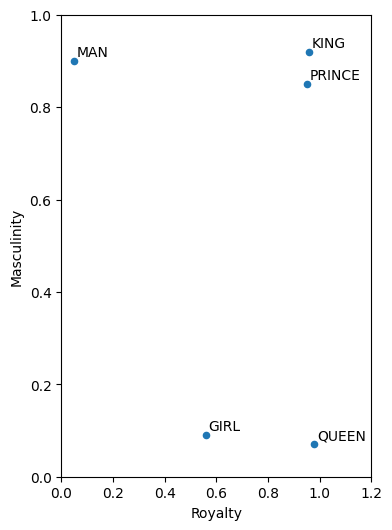

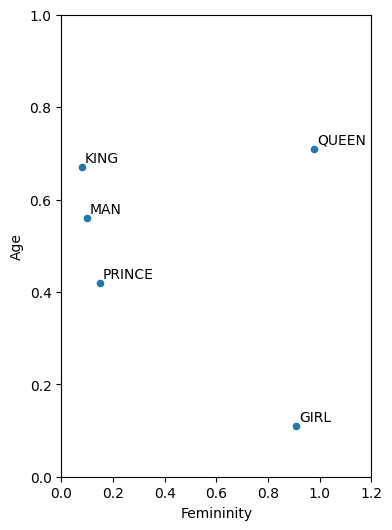

In [27]:
ax1 = medium_example.plot.scatter(x='Royalty', y='Masculinity', figsize=(4,6))
for k, v in medium_example[["Royalty", "Masculinity"]].iterrows():
    ax1.annotate(k, v+0.01)
ax1.set_xlim(0,1.2)
ax1.set_ylim(0,1)


ax2 = medium_example.plot.scatter(x='Femininity', y='Age', figsize=(4,6))
for k, v in medium_example[["Femininity", "Age"]].iterrows():
    ax2.annotate(k, v+0.01)
ax2.set_xlim(0,1.2)
ax2.set_ylim(0,1)


In [28]:
#adapted from lectures
def display_pca_scatterplot(words,  model=None, word_vectors=None, adjustment=0.5):

    if word_vectors is None:
        word_vectors = np.array([model(w).vector for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(12,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+adjustment, y+adjustment, word)

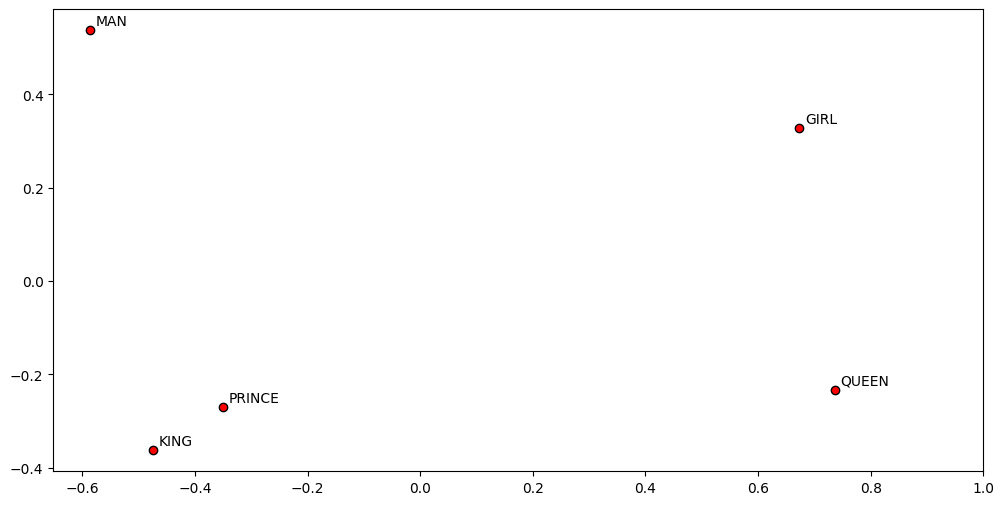

In [29]:
display_pca_scatterplot(medium_example.index, word_vectors=np.array(medium_example), adjustment=0.01)
plt.xlim(right=1.0)
plt.show()


In [30]:
#def display_pca_scatterplot(model, words=None, sample=0):
#    if words == None:
#        if sample > 0:
#            words = np.random.choice(list(model.key_to_index), sample)
#        else:
#            words = [ word for word in model.vocab ]
#
#    word_vectors = np.array([model(w).vector for w in words])
#
#    twodim = PCA().fit_transform(word_vectors)[:,:2]
#
#    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
#    plt.figure(figsize=(12,6))
#    for word, (x,y) in zip(words, twodim):
#        plt.text(x+0.5, y+0.5, word)

In [31]:
cosine_similarity([nlp("king").vector], [nlp("girl").vector])[0][0]

0.22843453

In [32]:
nlp("king").similarity(nlp("girl"))

0.228434522148802

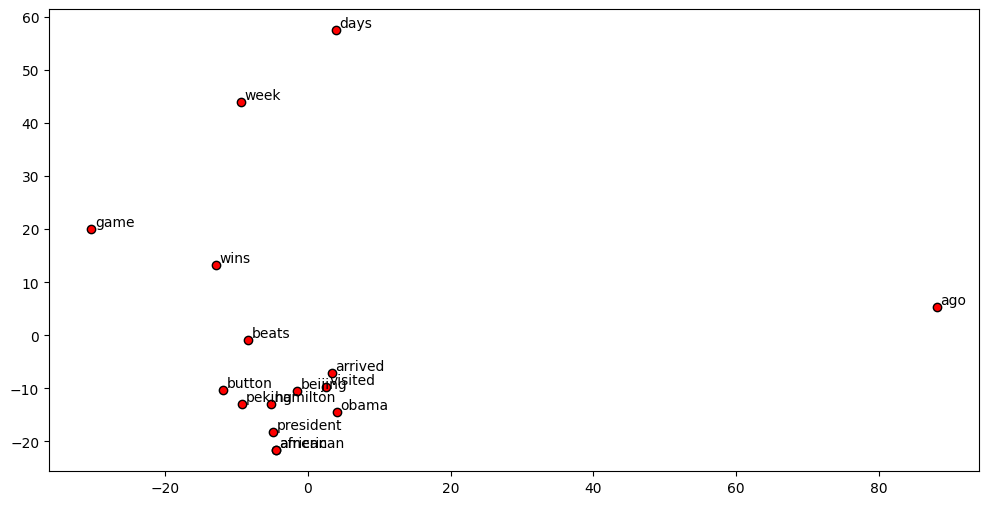

In [33]:
display_pca_scatterplot(vec.get_feature_names_out().tolist(), model=nlp)

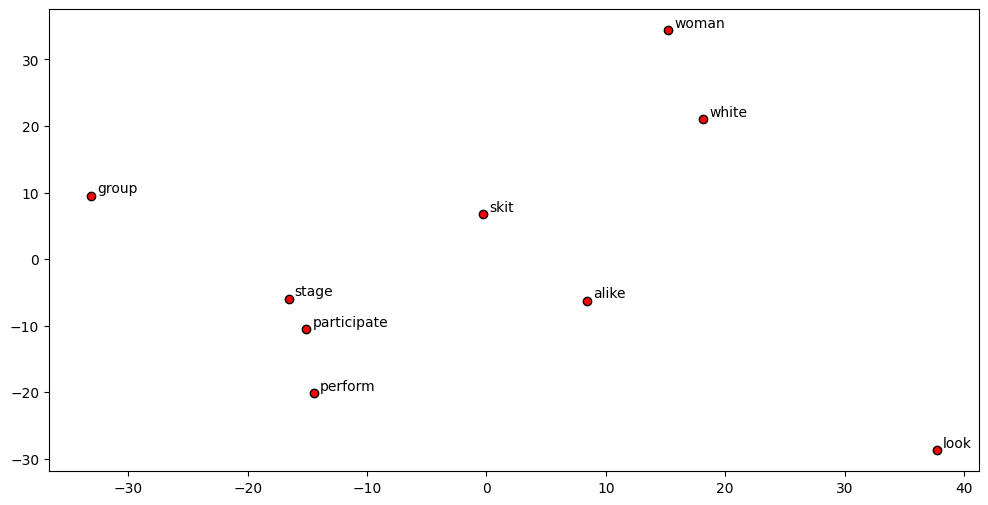

In [34]:
display_pca_scatterplot(dictionary.tolist(), model=nlp)

In [35]:
nlp(pic11013[4])

People in a dance

In [36]:
(nlp(pic11013[4]).vector == np.mean([nlp("People").vector,nlp("in").vector,nlp("a").vector,nlp("dance").vector],axis=0)).all()

True

In [37]:
nlp(pic11013[0]).vector.shape

(300,)

# Part II

In [38]:
pic2 = pictures.iloc[2]['set']
pic16 = pictures.iloc[16]['set']
pic94 = pictures.iloc[94]['set']
pic19521 = pictures.iloc[19521]['set']
pic31782 = pictures.iloc[31782]['set']

In [39]:
processed_pic2 = process(pic2, prints=False)

Original: 
['A child in a pink dress is climbing up a set of stairs in an entry way.', 'A girl going into a wooden building.', 'A little girl climbing into a wooden playhouse', 'A little girl in a pink dress going into a wooden cabin.', 'A little girl climbing the stairs to her playhouse.']
Processed
['child pink dress climb set stair entry way', 'girl wooden building', 'little girl climb wooden playhouse', 'little girl pink dress wooden cabin', 'little girl climb stair playhouse']


In [40]:
processed_pic16 = process(pic16, prints=False)

Original: 
['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl.', 'A little girl is sitting in front of a large painted rainbow.', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it.', 'There is a girl with pigtails sitting in front of a rainbow painting.', 'Young girl with pigtails painting outside in the grass.']
Processed
['little girl cover paint sit paint rainbow hand bowl', 'little girl sit large paint rainbow', 'small girl grass play fingerpaint white canvas rainbow', 'girl pigtail sit rainbow painting', 'young girl pigtail paint outside grass']


In [41]:
pic_sentence_labels = [n+l for n in ['1','2','3'] for l in ['A','B','C','D','E']]

In [42]:
cv = CountVectorizer()
X3 = cv.fit_transform(processed_pic11013+processed_pic2+processed_pic16)
cv.get_feature_names_out()

array(['alike', 'bowl', 'building', 'cabin', 'canvas', 'child', 'climb',
       'cover', 'dance', 'dress', 'entry', 'fingerpaint', 'girl', 'grass',
       'group', 'hand', 'large', 'little', 'look', 'outside', 'paint',
       'painting', 'participate', 'people', 'perform', 'pigtail', 'pink',
       'play', 'playhouse', 'rainbow', 'set', 'sit', 'skit', 'small',
       'stage', 'stair', 'way', 'white', 'woman', 'wooden', 'young'],
      dtype=object)

<Axes: >

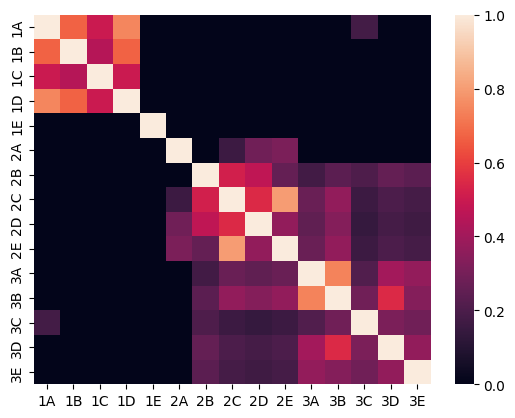

In [43]:
sns.heatmap(cosine_similarity(X3), xticklabels=pic_sentence_labels, yticklabels=pic_sentence_labels)

In [44]:
from sklearn.cluster import KMeans
cls = KMeans(n_clusters=3)
cls.fit_predict(X3)

# to get cluster labels for the dataset used while
# training the model (used for models that do not
# support prediction on new dataset).
cls.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int32)

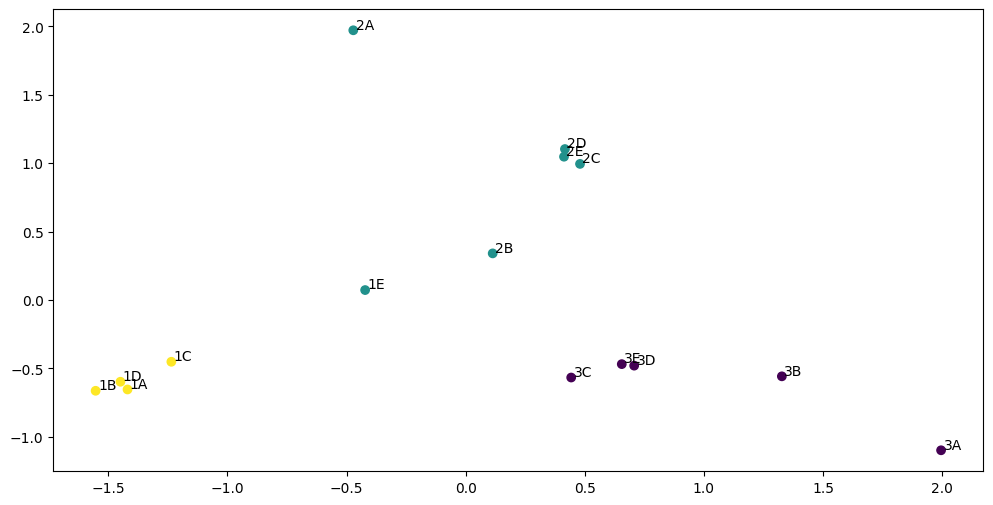

In [45]:
twodim = PCA().fit_transform(X3.toarray())[:,:2]
plt.figure(figsize=(12,6))
plt.scatter(twodim[:,0], twodim[:,1], c=cls.labels_)
for word, (x,y) in zip(pic_sentence_labels, twodim):
    plt.text(x+0.01, y+0.01, word)
plt.show()

In [46]:
vectorizer = TfidfVectorizer(smooth_idf=False)
tfidf_matrix = vectorizer.fit_transform(processed_pic11013+processed_pic16+processed_pic2)
vectorizer.get_feature_names_out()

array(['alike', 'bowl', 'building', 'cabin', 'canvas', 'child', 'climb',
       'cover', 'dance', 'dress', 'entry', 'fingerpaint', 'girl', 'grass',
       'group', 'hand', 'large', 'little', 'look', 'outside', 'paint',
       'painting', 'participate', 'people', 'perform', 'pigtail', 'pink',
       'play', 'playhouse', 'rainbow', 'set', 'sit', 'skit', 'small',
       'stage', 'stair', 'way', 'white', 'woman', 'wooden', 'young'],
      dtype=object)

In [47]:
vectorizer.idf_

array([3.7080502 , 3.7080502 , 3.7080502 , 3.7080502 , 3.7080502 ,
       3.7080502 , 2.60943791, 3.7080502 , 3.7080502 , 3.01490302,
       3.7080502 , 3.7080502 , 1.51082562, 3.01490302, 3.7080502 ,
       3.7080502 , 3.7080502 , 2.09861229, 3.7080502 , 3.7080502 ,
       2.60943791, 3.7080502 , 3.7080502 , 3.7080502 , 2.60943791,
       3.01490302, 3.01490302, 3.7080502 , 3.01490302, 2.32175584,
       3.7080502 , 2.60943791, 3.7080502 , 3.7080502 , 2.32175584,
       3.01490302, 3.7080502 , 3.01490302, 2.32175584, 2.60943791,
       3.7080502 ])

In [48]:
tfidf_matrix

<15x41 sparse matrix of type '<class 'numpy.float64'>'
	with 79 stored elements in Compressed Sparse Row format>

<Axes: >

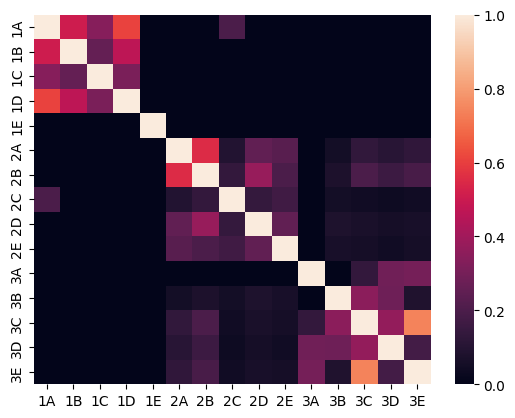

In [49]:
import seaborn as sns
sns.heatmap(cosine_similarity(tfidf_matrix), xticklabels=pic_sentence_labels, yticklabels=pic_sentence_labels )

In [50]:
cls = KMeans(n_clusters=3)
cls.fit_predict(tfidf_matrix)

# to get cluster labels for the dataset used while
# training the model (used for models that do not
# support prediction on new dataset).
cls.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2], dtype=int32)

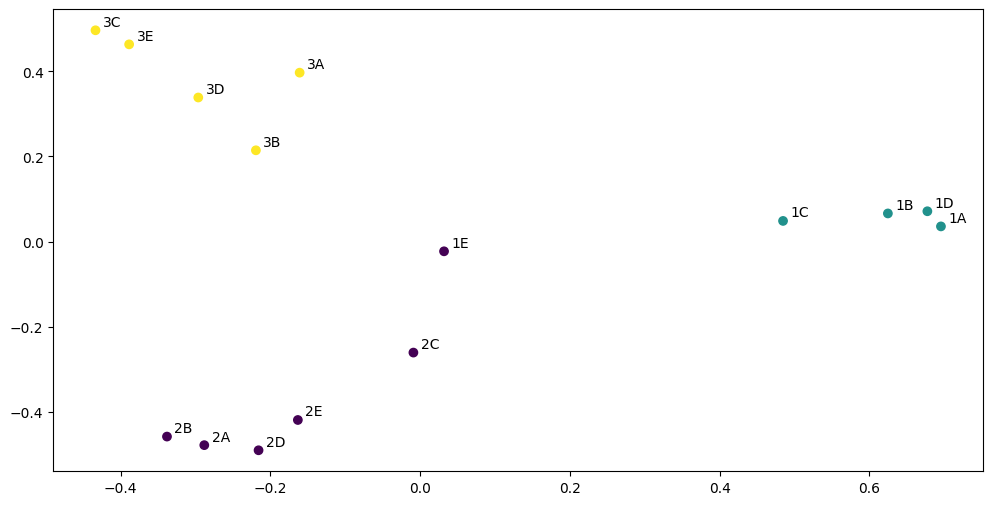

In [51]:
twodim = PCA().fit_transform(np.array(tfidf_matrix.todense()))[:,:2]
plt.figure(figsize=(12,6))
plt.scatter(twodim[:,0], twodim[:,1], c=cls.labels_)
for word, (x,y) in zip(pic_sentence_labels, twodim):
    plt.text(x+0.01, y+0.01, word)
plt.show()

In [52]:
len(pictures['set'].tolist())

31783

In [53]:
len([caption for captions in pictures['set'] for caption in captions])

158881

In [54]:
vectorizer_all = TfidfVectorizer()
vectorizer_all.fit([caption for captions in pictures['set'] for caption in captions])


TfidfVectorizer()

In [55]:
tfidf_matrix_all = vectorizer_all.transform(processed_pic11013+processed_pic16+processed_pic2)

In [56]:
print(tfidf_matrix_all.size/(tfidf_matrix_all.shape[0]*tfidf_matrix_all.shape[1]))
tfidf_matrix_all

0.0002849002849002849


<15x18252 sparse matrix of type '<class 'numpy.float64'>'
	with 78 stored elements in Compressed Sparse Row format>

<Axes: >

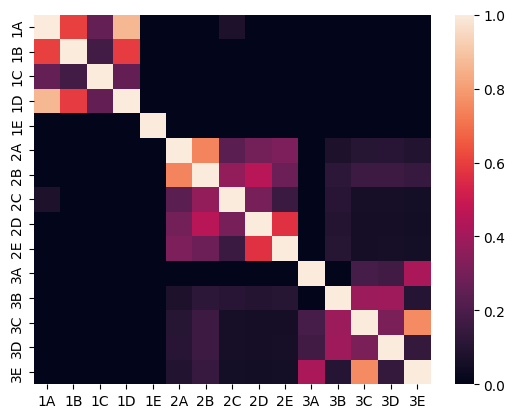

In [57]:
sns.heatmap(cosine_similarity(tfidf_matrix_all), xticklabels=pic_sentence_labels, yticklabels=pic_sentence_labels)

In [58]:
dictionary

array(['alike', 'group', 'look', 'participate', 'perform', 'skit',
       'stage', 'white', 'woman'], dtype=object)

In [59]:
nlp11013 = []
nlp2 = []
nlp16 = []
nlp31782 = []
for i in range(5):
  nlp11013.append(nlp(pic11013[i]).vector)
  nlp2.append(nlp(pic2[i]).vector)
  nlp16.append(nlp(pic16[i]).vector)
  nlp31782.append(nlp(pic31782[i]).vector)

<Axes: >

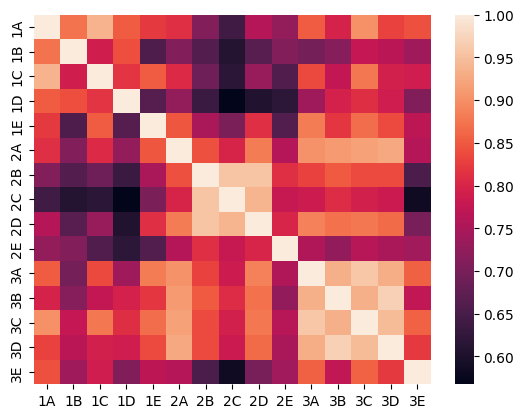

In [60]:
sns.heatmap(cosine_similarity(nlp11013+nlp2+nlp16), xticklabels=pic_sentence_labels,yticklabels=pic_sentence_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


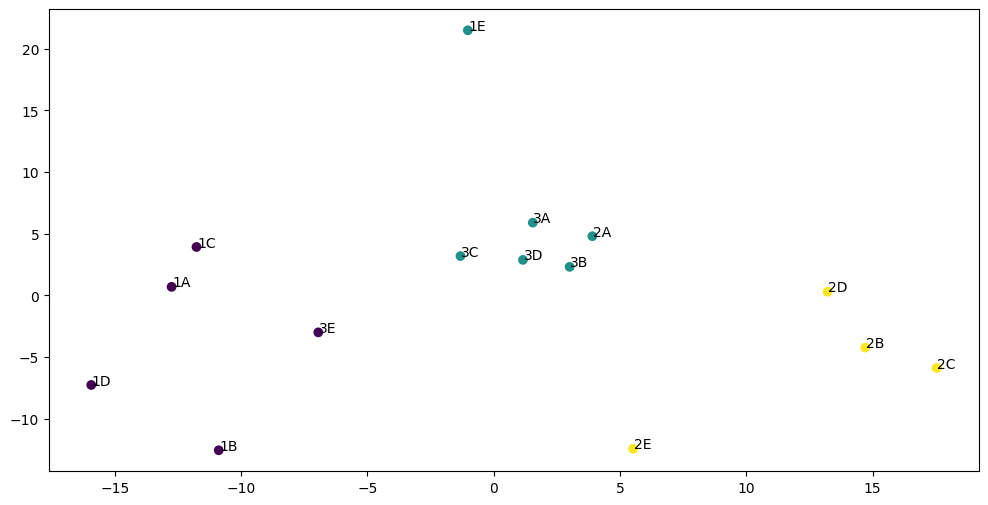

In [61]:
cls = KMeans(n_clusters=3)
cls.fit_predict(nlp11013+nlp2+nlp16)

# to get cluster labels for the dataset used while
# training the model (used for models that do not
# support prediction on new dataset).
cls.labels_

twodim = PCA().fit_transform(nlp11013+nlp2+nlp16)[:,:2]
plt.figure(figsize=(12,6))
plt.scatter(twodim[:,0], twodim[:,1], c=cls.labels_)
for word, (x,y) in zip(pic_sentence_labels, twodim):
    plt.text(x+0.02, y+0.01, word)
plt.show()

new bit

part II

from pics.ipynb

In [62]:
pictures = pd.DataFrame(pictures['set'].to_list(), columns=['caption1','caption2', 'caption3','caption4','caption5'])

In [63]:
pictures.dropna(inplace=True)

In [64]:
# Select 300 random rows
pics = pictures.sample(n=300, random_state=42) #, ignore_index=True)
pics

,caption1,caption2,caption3,caption4,caption5
4222,A bald man is about to cook some kind of fish.,"A bald man is cooking on a stove, throwing a s...",Adult white male holding a blue crab over a po...,A Shaved man about to put a blue crab in a boi...,A bald man picking up a blue crap with tongs a...
29122,A woman dressed with a pink jacket and jeans i...,A Spanish looking woman carries a heavy red ba...,A woman is walking in front of graffiti-covere...,A middle-aged woman is hauling a large red bag...,An older woman is carrying a large red sack in...
19229,A child looking at desserts with awe.,A child with blond-hair is looking at a select...,A little boy with blond-hair stares down at di...,A little kid is admiring the display in a bake...,A kid looking at cookies in a bakery.
14111,A group of people are standing around a red fi...,A group of people with a fire engine in the ba...,A group of people are standing beside a firetr...,A group of people in front of a red firetruck.,A red firetruck is parked beside a group of pe...
3908,A child runs on a dirt path along the street.,"Little boy in walking shorts and sweater, on t...",A small boy in an orange hat running.,a little boy plays at the zoo.,A young boy in a red cap catching up with his ...
...,...,...,...,...,...
20395,A crowd of people listening to a speech.,A large group of people is gathered in front o...,A group of people stand watching something ahead.,A large group of people are gathered outside o...,A large group of people are gathered around a ...
8866,A man is riding a tall unicycle and juggling p...,A man in a bright yellow shirt juggles while r...,"Man on a tall unicycle, who is wearing bright ...",A man wearing a yellow shirt riding a unicycle...,A street performer entertains a group of peopl...
10555,A group of women sit on the back of a flatbed ...,Several people are sitting on the back of a tr...,"a crowd gather together, all looking in the sa...",People sitting on the roof observing something...,Eight people sit on railroad tracks.
21966,Three men and a small crowd of other people wa...,Three young men in a crowd watching tennis on ...,Three young men are watching a tennis match on...,three young men stand behind a net watching a ...,Three young men discuss a sports match from th...


In [65]:
def create_corpus(documents):
  corpus = []
  for document_set in documents:
    words = document_set.str.split()
    corpus.extend(words.to_list())

  return set([word for document in (corpus) for word in document])

In [66]:
len(create_corpus([pics["caption1"], pics["caption2"], pics["caption3"], pics["caption4"], pics["caption5"]]))

2923

In [67]:
pics["caption1_processed"] = pics.caption1.str.lower()
pics["caption2_processed"] = pics.caption2.str.lower()
len(create_corpus([pics["caption1_processed"], pics["caption2_processed"]]))

1707

In [68]:
pics["caption1_processed"] = pics["caption1_processed"].str.replace(r'[^\w\s]+', '', regex=True)
pics["caption2_processed"] = pics["caption2_processed"].str.replace(r'[^\w\s]+', '', regex=True)
len(create_corpus([pics["caption1_processed"], pics["caption2_processed"]]))

1436

In [69]:
pics["caption1_processed"] = pics["caption1_processed"].apply(lambda s: " ".join([word.lemma_ for word in nlp(s)]))
pics["caption2_processed"] = pics["caption2_processed"].apply(lambda s: " ".join([word.lemma_ for word in nlp(s)]))
len(create_corpus([pics["caption1_processed"], pics["caption2_processed"]]))

1223

In [70]:
pics["caption1_processed"] = pics["caption1_processed"].apply(lambda s: remove_stopwords(s))
pics["caption2_processed"] = pics["caption2_processed"].apply(lambda s: remove_stopwords(s))
len(create_corpus([pics["caption1_processed"], pics["caption2_processed"]]))

1100

In [71]:
pics["caption3_processed"] = pics.caption3.str.lower().str.replace(r'[^\w\s]+', '', regex=True).apply(lambda s: " ".join([word.lemma_ for word in nlp(s)])).apply(lambda s: remove_stopwords(s))
pics["caption4_processed"] = pics.caption4.str.lower().str.replace(r'[^\w\s]+', '', regex=True).apply(lambda s: " ".join([word.lemma_ for word in nlp(s)])).apply(lambda s: remove_stopwords(s))
pics["caption5_processed"] = pics.caption5.str.lower().str.replace(r'[^\w\s]+', '', regex=True).apply(lambda s: " ".join([word.lemma_ for word in nlp(s)])).apply(lambda s: remove_stopwords(s))

In [72]:
pics["Jaccard_Similarity"] = pics.apply(lambda x: Jaccard(x.caption1, x.caption2), axis=1)
sim_cols = ["Jaccard_Similarity"]

In [73]:
pics["Jaccard_Similarity_processed"] = pics.apply(lambda x: Jaccard(x.caption1_processed, x.caption2_processed), axis=1)
sim_cols.append("Jaccard_Similarity_processed")

In [74]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(pics.caption1.tolist()+pics.caption2.tolist()+pics.caption3.tolist()+pics.caption4.tolist()+pics.caption5.tolist())
tfidf_matrix = np.resize(tfidf_matrix.toarray(),(5,300,tfidf_matrix.shape[-1]))
for i in range(5):
  pics[f"caption{i+1}_tfidf"] = tfidf_matrix[i].tolist()

In [75]:
pics["TfIdf_Similarity"] = pics.apply(lambda x: cosine_similarity([x.caption1_tfidf], [x.caption2_tfidf])[0][0], axis=1)
sim_cols.append("TfIdf_Similarity")

In [76]:
ppvectorizer = TfidfVectorizer()
tfidf_matrix_processed = ppvectorizer.fit_transform(pics.caption1_processed.tolist()+pics.caption2_processed.tolist()+pics.caption3_processed.tolist()+pics.caption4_processed.tolist()+pics.caption5_processed.tolist())
tfidf_matrix_processed = np.resize(tfidf_matrix_processed.toarray(),(5,300,tfidf_matrix_processed.shape[-1]))
for i in range(5):
  pics[f"caption{i+1}_processed_tfidf"] = tfidf_matrix_processed[i].tolist()

In [77]:
pics["TfIdf_Similarity_processed"] = pics.apply(lambda x: cosine_similarity([x.caption1_processed_tfidf], [x.caption2_processed_tfidf])[0][0], axis=1)
sim_cols.append("TfIdf_Similarity_processed")

In [78]:
tfidf_matrix_all = vectorizer_all.transform(pics.caption1.tolist()+pics.caption2.tolist()+pics.caption3.tolist()+pics.caption4.tolist()+pics.caption5.tolist())
tfidf_matrix_all = np.resize(tfidf_matrix_all.toarray(),(5,300,tfidf_matrix_all.shape[-1]))
for i in range(5):
  pics[f"caption{i+1}_all_tfidf"] = tfidf_matrix_all[i].tolist()

In [79]:
pics["TfIdf_Similarity_all"] = pics.apply(lambda x: cosine_similarity([x.caption1_all_tfidf], [x.caption2_all_tfidf])[0][0], axis=1)
sim_cols.append("TfIdf_Similarity_all")

In [80]:
pics["caption1_spacy"] = pics.apply(lambda x: nlp(x.caption1), axis=1)
pics["caption2_spacy"] = pics.apply(lambda x: nlp(x.caption2), axis=1)

In [81]:
pics["Spacy_Similarity"] = pics.apply(lambda x: x.caption1_spacy.similarity(x.caption2_spacy), axis=1)
sim_cols.append("Spacy_Similarity")

In [82]:
pics["caption1_spacy_processed"] = pics.apply(lambda x: nlp(x.caption1_processed), axis=1)
pics["caption2_spacy_processed"] = pics.apply(lambda x: nlp(x.caption2_processed), axis=1)

In [83]:
pics["Spacy_Similarity_processed"] = pics.apply(lambda x: x.caption1_spacy_processed.similarity(x.caption2_spacy_processed), axis=1)
sim_cols.append("Spacy_Similarity_processed")

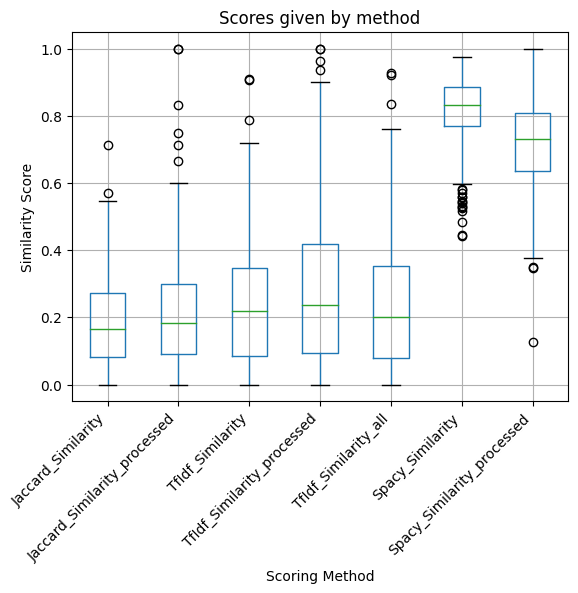

In [84]:
pics.boxplot(column=sim_cols)
plt.xticks(rotation=45, ha='right')
plt.title("Scores given by method")
plt.ylabel("Similarity Score")
plt.xlabel("Scoring Method")
plt.show()

In [85]:
def logloss(df,col,sim):
  return -sim*sum(np.log(df[col]+0.001))/len(df)-(1-sim)*sum(np.log(1-df[col]+0.001)/len(df))

In [86]:
log_loss = []
for col in sim_cols:
  log_loss.extend([[col, logloss(pics,col,True)]])
lldf = pd.DataFrame(log_loss,columns=["Scoring Method","Log Loss"])
print(lldf)

                 Scoring Method  Log Loss
0            Jaccard_Similarity  2.015858
1  Jaccard_Similarity_processed  2.394611
2              TfIdf_Similarity  2.117084
3    TfIdf_Similarity_processed  2.222744
4          TfIdf_Similarity_all  2.165021
5              Spacy_Similarity  0.214195
6    Spacy_Similarity_processed  0.356237


# Negging

In [87]:
pics.columns

Index(['caption1', 'caption2', 'caption3', 'caption4', 'caption5',
       'caption1_processed', 'caption2_processed', 'caption3_processed',
       'caption4_processed', 'caption5_processed', 'Jaccard_Similarity',
       'Jaccard_Similarity_processed', 'caption1_tfidf', 'caption2_tfidf',
       'caption3_tfidf', 'caption4_tfidf', 'caption5_tfidf',
       'TfIdf_Similarity', 'caption1_processed_tfidf',
       'caption2_processed_tfidf', 'caption3_processed_tfidf',
       'caption4_processed_tfidf', 'caption5_processed_tfidf',
       'TfIdf_Similarity_processed', 'caption1_all_tfidf',
       'caption2_all_tfidf', 'caption3_all_tfidf', 'caption4_all_tfidf',
       'caption5_all_tfidf', 'TfIdf_Similarity_all', 'caption1_spacy',
       'caption2_spacy', 'Spacy_Similarity', 'caption1_spacy_processed',
       'caption2_spacy_processed', 'Spacy_Similarity_processed'],
      dtype='object')

In [88]:
import random
random.seed(7)
caption_pairs = pd.DataFrame()
pic_nos = pics.index.to_list()
random.shuffle(pic_nos)
caption_pairs["one"] = pic_nos
random.shuffle(pic_nos)
caption_pairs["two"] = pic_nos

,one,two
0,5777,5805
1,6875,6543
2,6209,12039
3,3908,3050
4,1792,8291
...,...,...
295,28718,19872
296,22251,4276
297,9783,20407
298,6543,5541


In [89]:
#pic_nos = pics.index.to_list()

#cols = ["caption1", "caption1_processed", "caption1_tfidf_sklearn",
#        'caption1_spacy', "caption1_sbert", "caption1_sbert_processed"
#        ]
#caption_pairs = [pd.DataFrame(cols),pd.DataFrame(cols)]
#for i in range(2):
#  random.shuffle(pic_nos)
#  caption_pairs = pics[cols].loc[movieIDs].reset_index(drop=True)
#  caption_pairs.columns = [f'{col}_{i+1}' for col in caption2s[i].columns]

In [90]:
sum(caption_pairs["one"] == caption_pairs["two"])

0

In [92]:
caption_pairs["Jaccard_Similarity"] = caption_pairs.apply(lambda x: Jaccard(pics["caption1"][x.one], pics["caption1"][x.two]), axis=1)
caption_pairs["Jaccard_Similarity_processed"] = caption_pairs.apply(lambda x: Jaccard(pics["caption1_processed"][x.one], pics["caption1_processed"][x.two]), axis=1)
caption_pairs["TfIdf_Similarity"] = caption_pairs.apply(lambda x: cosine_similarity([pics["caption1_tfidf"][x.one]], [pics["caption1_tfidf"][x.two]])[0][0], axis=1)
caption_pairs["TfIdf_Similarity_processed"] = caption_pairs.apply(lambda x: cosine_similarity([pics["caption1_processed_tfidf"][x.one]], [pics["caption1_processed_tfidf"][x.two]])[0][0], axis=1)
caption_pairs["TfIdf_Similarity_all"] = caption_pairs.apply(lambda x: cosine_similarity([pics["caption1_all_tfidf"][x.one]], [pics["caption1_all_tfidf"][x.two]])[0][0], axis=1)
caption_pairs["Spacy_Similarity_processed"] = caption_pairs.apply(lambda x: pics["caption1_spacy_processed"][x.one].similarity(pics["caption1_spacy_processed"][x.two]), axis=1)
caption_pairs["Spacy_Similarity"] = caption_pairs.apply(lambda x: pics["caption1_spacy"][x.one].similarity(pics["caption1_spacy"][x.two]), axis=1)

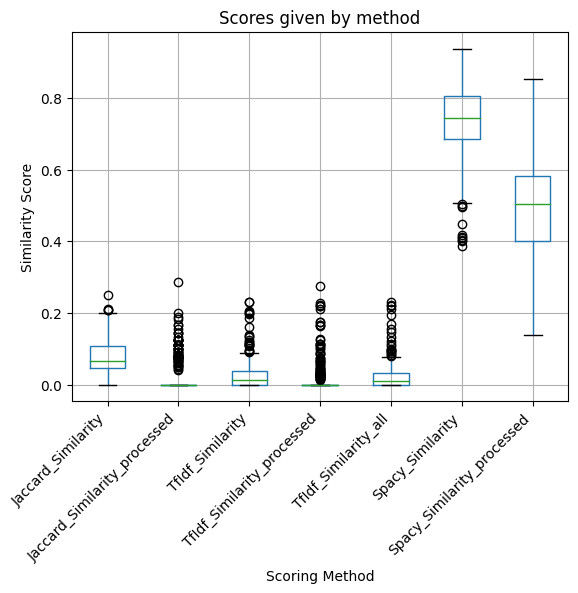

In [93]:
caption_pairs.boxplot(column=sim_cols)
plt.xticks(rotation=45, ha='right')
plt.title("Scores given by method")
plt.ylabel("Similarity Score")
plt.xlabel("Scoring Method")
plt.show()

In [94]:
ll = []
for col in sim_cols:
  ll.extend([[col,logloss(caption_pairs,col,False)]])
llS = pd.DataFrame(ll,columns=["Scoring Method","Log Loss Diff"])

In [95]:
LL = pd.merge(lldf,llS)
LL.columns = ["Scoring Method","Log Loss Sim","Log Loss Diff"]
LL["Overall Log Loss"] = (LL["Log Loss Diff"]+LL["Log Loss Sim"])/2
LL

,Scoring Method,Log Loss Sim,Log Loss Diff,Overall Log Loss
0,Jaccard_Similarity,2.015858,0.080545,1.048202
1,Jaccard_Similarity_processed,2.394611,0.023198,1.208905
2,TfIdf_Similarity,2.117084,0.028344,1.072714
3,TfIdf_Similarity_processed,2.222744,0.017689,1.120216
4,TfIdf_Similarity_all,2.165021,0.024299,1.094660
5,Spacy_Similarity,0.214195,1.401692,0.807943
6,Spacy_Similarity_processed,0.356237,0.712765,0.534501


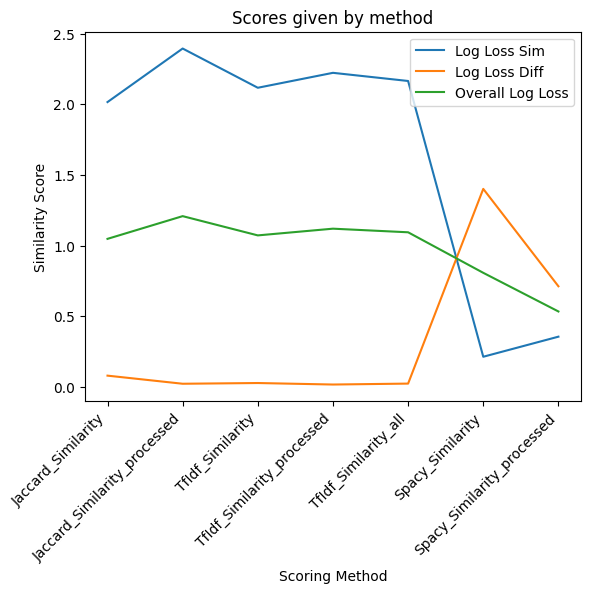

In [100]:
LL.plot.line(x="Scoring Method")
plt.xticks(rotation=45, ha='right')
plt.title("Scores given by method")
plt.ylabel("Similarity Score")
plt.xlabel("Scoring Method")
plt.show()

In [97]:

#df["sbert_Similarity"] = df.apply(lambda x: relu(cosine_similarity([x.caption1_sbert_1], [x.caption1_sbert_2])[0][0]), axis=1)
#df["sbert_Similarity_processed"] = df.apply(lambda x: relu(cosine_similarity([x.caption1_sbert_processed_1], [x.caption1_sbert_processed_2])[0][0]), axis=1)


In [98]:
from scipy.sparse import vstack
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [99]:
def pretty_picture(data, clusters):

SyntaxError: incomplete input (<ipython-input-99-709ea11eb461>, line 1)

In [ ]:

cls = KMeans(n_clusters=20)
cls.fit_predict(np.resize(tfidf_matrix[:,:20],(100,tfidf_matrix.shape[-1])))

# to get cluster labels for the dataset used while
# training the model (used for models that do not
# support prediction on new dataset).
cls.labels_

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'features' is your sparse matrix
# and it's already preprocessed appropriately

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=0, init="random")

# create the tsne arrangement of points in 2D (it is not really dimensionality reduction - it is arranging
# the points so that the most similar )
reduced_features = tsne.fit_transform(np.resize(tfidf_matrix[:,:20],(100,tfidf_matrix.shape[-1])))

# Plot
plt.figure(figsize=(10, 6))
plt.title('t-SNE Visualization of Data Items')
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=[pic for i in range(5) for pic in range(20)], cmap='tab20')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

In [ ]:
pics["TfIdf_Similarity_sklearn"] = pics.apply(lambda x: cosine_similarity([x.caption1_tfidf_sklearn], [x.caption2_tfidf_sklearn])[0][0], axis=1)
sim_cols.append("TfIdf_Similarity_sklearn")

In [ ]:
print(tfidf_matrix.shape)
print(tfidf_matrix.size)
print(tfidf_matrix.shape[0]*tfidf_matrix.shape[1])
tfidf_matrix

In [ ]:
tfidf_matrix.size/(tfidf_matrix.shape[0]*tfidf_matrix.shape[1])

In [ ]:
ppvectorizer = TfidfVectorizer()
tfidf_matrix_processed = ppvectorizer.fit_transform(pics.caption1_processed.tolist()+pics.caption2_processed.tolist()+pics.caption3_processed.tolist()+pics.caption4_processed.tolist()+pics.caption5_processed.tolist())
tfidf_matrix = np.resize(tfidf_matrix.toarray(),(5,300,2217))
for i in range(5):
  pics[f"caption{i+1}_tfidf_sklearn"] = tfidf_matrix[i].tolist()

In [ ]:
pics["TfIdf_Similarity_sklearn_processed"] = pics.apply(lambda x: cosine_similarity([x.caption1_processed_tfidf_sklearn], [x.caption2_processed_tfidf_sklearn])[0][0], axis=1)
sim_cols.append("TfIdf_Similarity_sklearn_processed")